In [1]:
import numpy as np
import pandas as pd
from functions import *
from schemes import *
from plot import * 

%matplotlib inline

#### Ground Truth 

In [2]:
def SolveKepler(e, M):
    E0 = M
    while True:
        E1 = E0 - (E0 - e * np.sin(E0) - M) / (1 - e * np.cos(E0))
        if np.linalg.norm(E1 - E0) < 1e-8:
            return E1
        E0 = E1

def KeplerOrbit(a, e, mu, t):
    T = KeplerPeriod(a, mu)
    M = 2 * np.pi * t / T
    E = SolveKepler(e, M)
    theta = 2 * np.arctan2(np.sqrt(1 + e) * np.sin(E/2), np.sqrt(1 - e) * np.cos(E/2))
    r = a * (1 - e**2) / (1 + e * np.cos(theta))
    x = r * np.cos(theta)
    y = r * np.sin(theta)
    z = np.zeros_like(x)
    return np.column_stack((x, y, z))

def SemiMajorAxis(mu, r0s, v0s):
    r = r0s[1, :]
    v = v0s[1, :]
    R = np.linalg.norm(r2)
    a = mu * R / (2 * mu - R * (v[0] ** 2 + v[1] ** 2))
    return a

def KeplerPeriod(a, mu): return 2 * np.pi * np.sqrt(a**3 / mu)

In [3]:
# gravity
G = 1

# mass ratio & eccentricity 
q = 1.0 # q = m2 / m1
e = 0.8

m1 = 1 # central mass
m2 = q # orbiting mass
mu = G * (m1 + m2) 

# position
r1 = np.array([0,0.0,0.0], dtype="float64")
r2 = np.array([1,0.0,0.0], dtype="float64")

# velocity 
v1 = np.array([0,0.0,0], dtype="float64")
v2 = np.array([0,np.sqrt((1 + q)*(1 + e)),0], dtype="float64")

# create initial vectors
r0s = np.array([r1,r2])
v0s = np.array([v1,v2])
masses = np.array([m1, m2])

In [4]:
a = SemiMajorAxis(mu, r0s, v0s)

# Generate time values spanning one orbital period
num_points = 1000
T = 2 * np.pi * np.sqrt(a**3 / mu)
t_values = np.linspace(0, T, num_points)

# Calculate the position of the orbit at each time
kepler_traj = KeplerOrbit(a, e, mu, t_values)

In [5]:
# reposition centre of mass to origin with no momentum 
rcom, vcom = CentreOfMass(r0s, v0s, masses)
r0s -= rcom
v0s -= vcom

traj = run_scheme(EulerStep, 0, 50, 0.01, r0s, v0s, G, masses)

In [6]:
a = SemiMajorAxis(mu, r0s, v0s)
T = KeplerPeriod(a, mu)
t_traj = np.array(traj[0]) 

# Calculate the position of the orbit at each time
kepler_traj = KeplerOrbit(a, e, mu, t_traj)

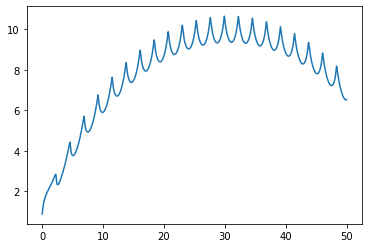

In [7]:
rs_traj = traj[1]
err = kepler_traj - rs_traj[:,1,:]
errors = np.linalg.norm(err, axis = 1)
errors_series = pd.Series(errors)

# Specify the window size for the rolling average
window_size = 10000

# Calculate the rolling average using pandas
rolling_average = errors_series.rolling(window=window_size).mean()

plt.plot(t_traj, errors)
plt.plot(t_traj, rolling_average)

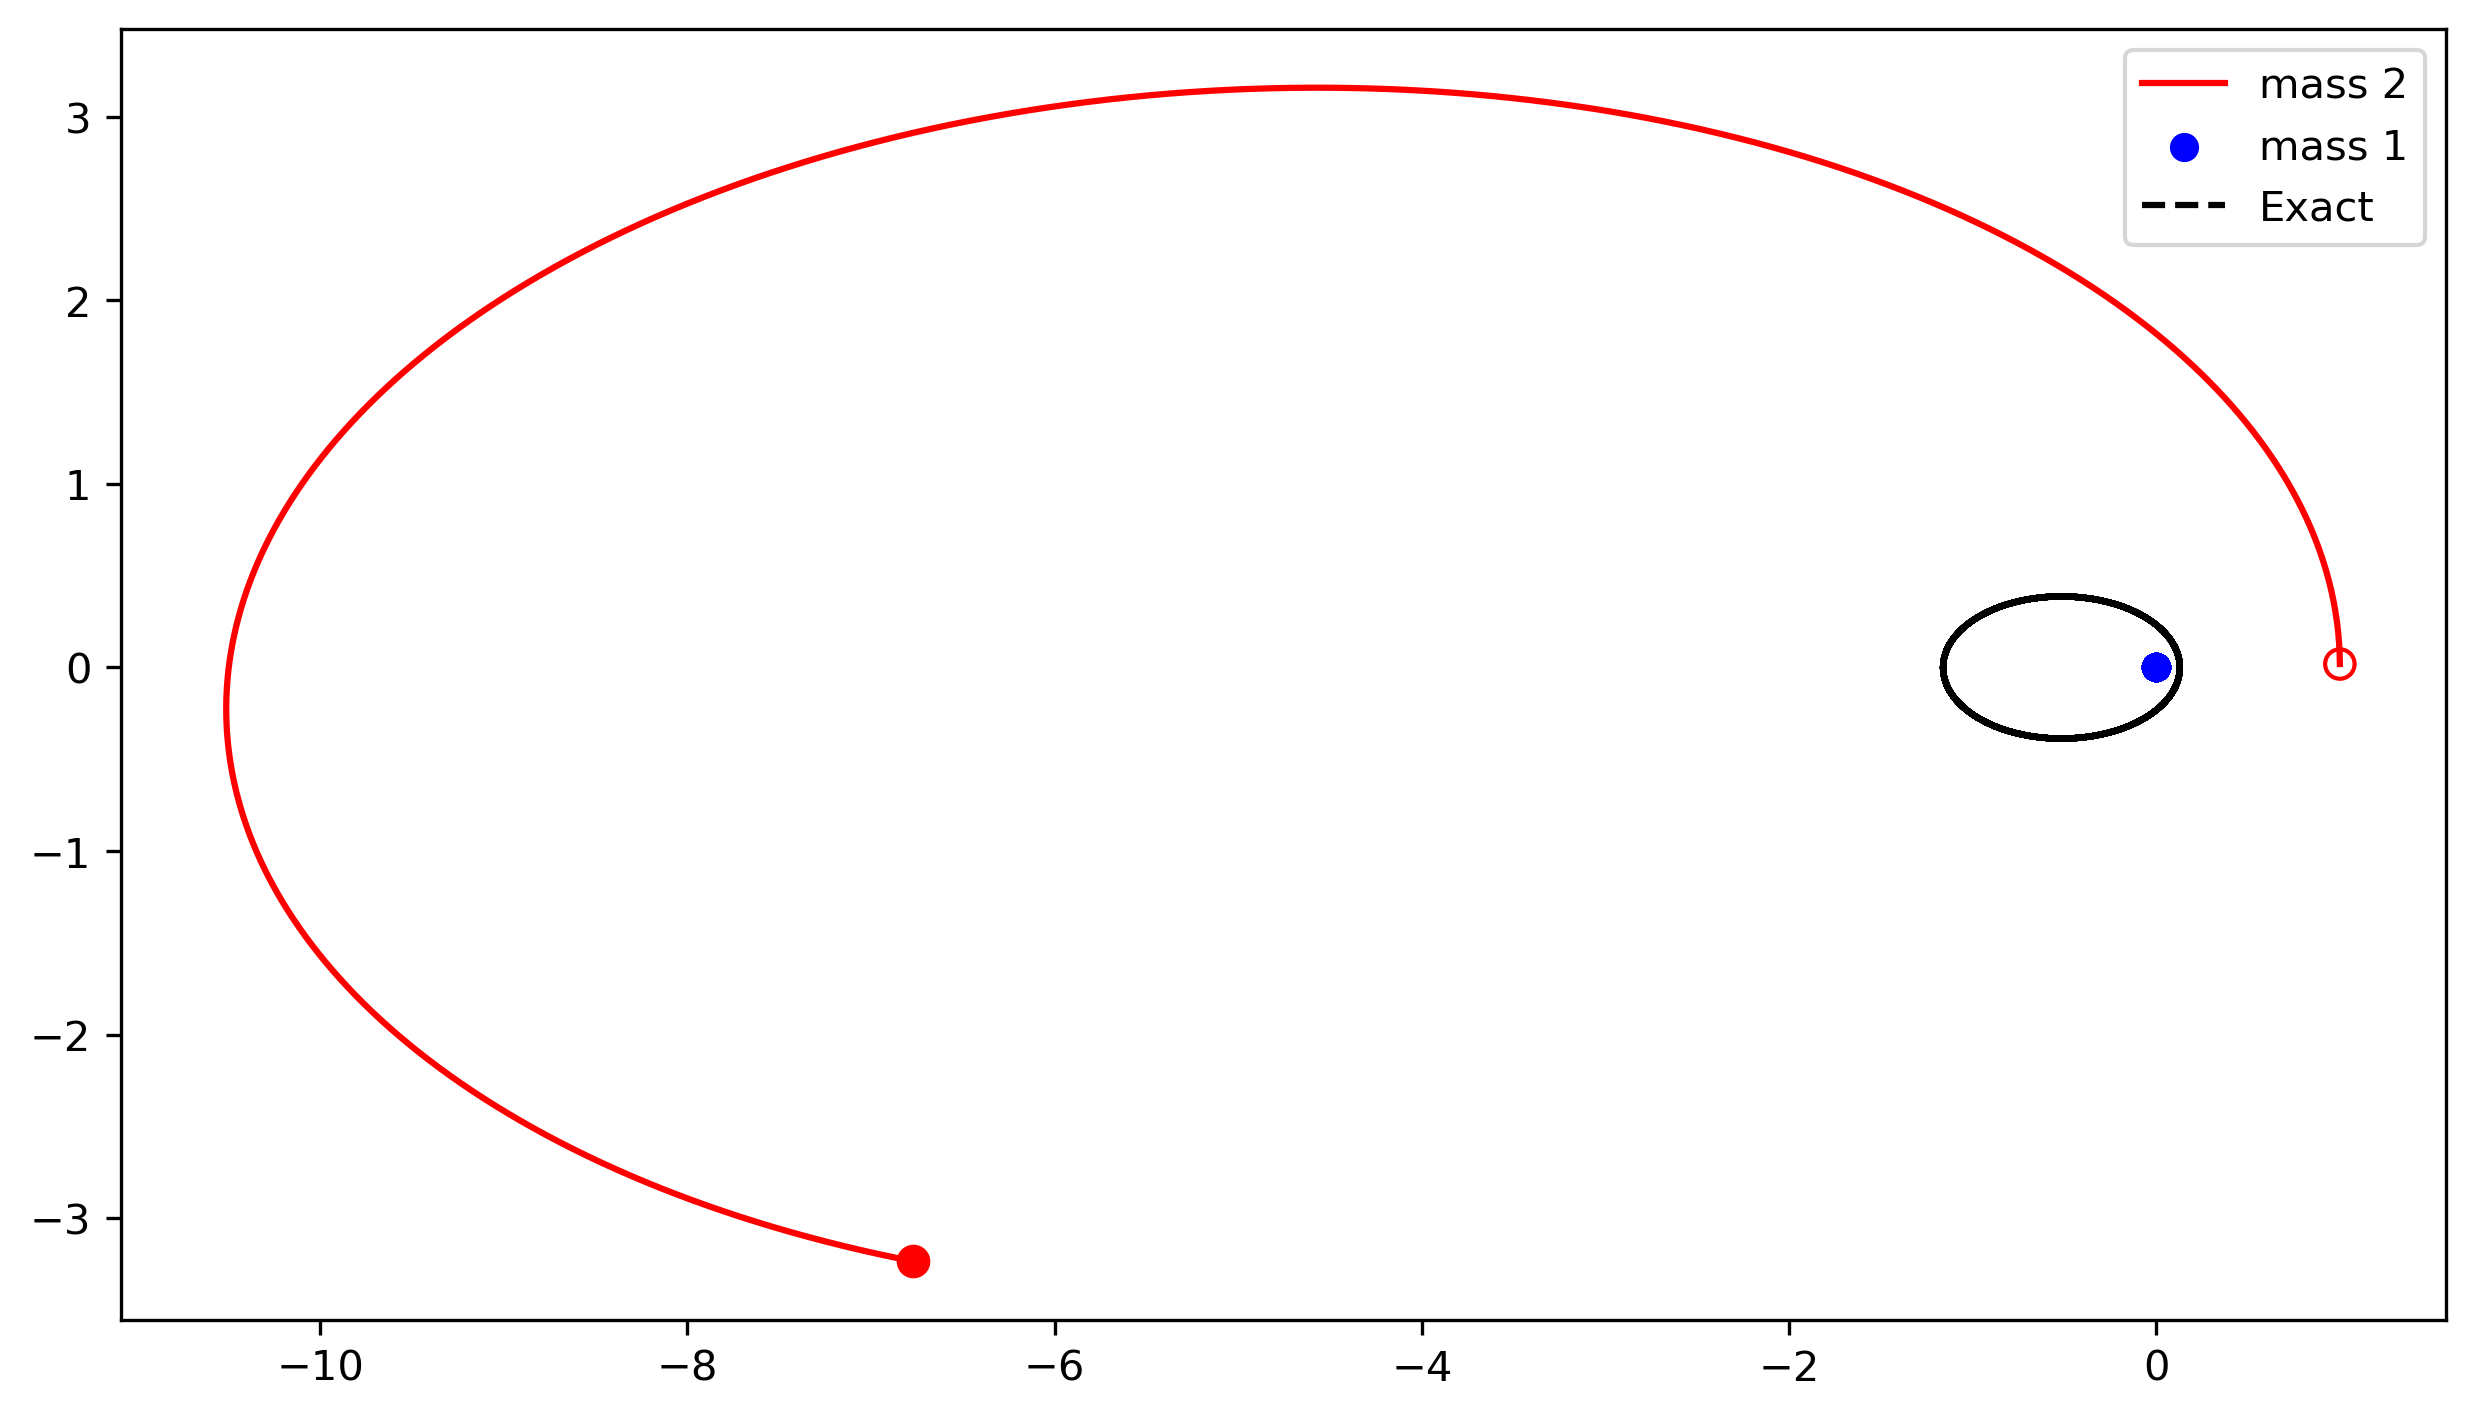

In [8]:
t_traj, rs_traj, vs_traj, ke_traj, pe_traj, am_traj = traj
N = rs_traj.shape[1] # number of masses in the system

plt.style.use('default')

# create figure
fig = plt.figure(figsize = (10,10), dpi = 300)

ax = fig.add_subplot(111,aspect='equal')

### ORBITS ###

ax.plot(rs_traj[:,1,0], rs_traj[:,1,1], label=f'mass 2', color = 'red') # plot the orbits
ax.scatter(rs_traj[:,0,0], rs_traj[:,0,1], label=f'mass 1', color = 'blue')
ax.scatter(rs_traj[0,1,0],rs_traj[0,1,1], marker="o", facecolors='none', s=50, color ='red') # plot the start positions
ax.scatter(rs_traj[-1,1,0],rs_traj[-1,1,1], marker="o",s=50, color = 'red') # plot the final positions of the

ax.plot(kepler_traj[:,0], kepler_traj[:,1], label = 'Exact', linestyle = '--', color = 'black')

plt.legend()

In [9]:
def AbsoluteError(scheme, r0s, v0s, T, h, G, m1, m2):
    mu = G * (m1 + m2) 
    
    # reposition centre of mass to origin with no momentum 
    rcom, vcom = CentreOfMass(r0s, v0s, masses)
    r0sprime = r0s - rcom
    v0sprime = v0s - vcom

    traj = run_scheme(EulerStep, 0, 50, 0.01, r0sprime, v0sprime, G, masses)
    
    a = SemiMajorAxis(mu, r0s, v0s)
    
    t_traj = np.array(traj[0]) 
    rs_traj = traj[1]

    kepler_traj = KeplerOrbit(a, e, mu, t_traj)
    
    errs = kepler_traj - rs_traj[:,1,:]
    errs = np.linalg.norm(errs, axis = 1)

    return errs, traj, kepler_traj

#### Error

In [10]:
# gravity
G = 1

# mass ratio & eccentricity 
q = 1.0 # q = m2 / m1
e = 0.6

m1 = 1 # central mass
m2 = q # orbiting mass
mu = G * (m1 + m2) 

# position
r1 = np.array([0,0.0,0.0], dtype="float64")
r2 = np.array([1,0.0,0.0], dtype="float64")

# velocity 
v1 = np.array([0,0.0,0], dtype="float64")
v2 = np.array([0,np.sqrt((1 + q)*(1 + e)),0], dtype="float64")

# create initial vectors
r0s = np.array([r1,r2])
v0s = np.array([v1,v2])
masses = np.array([m1, m2])

In [11]:
T = 100
h = 0.01

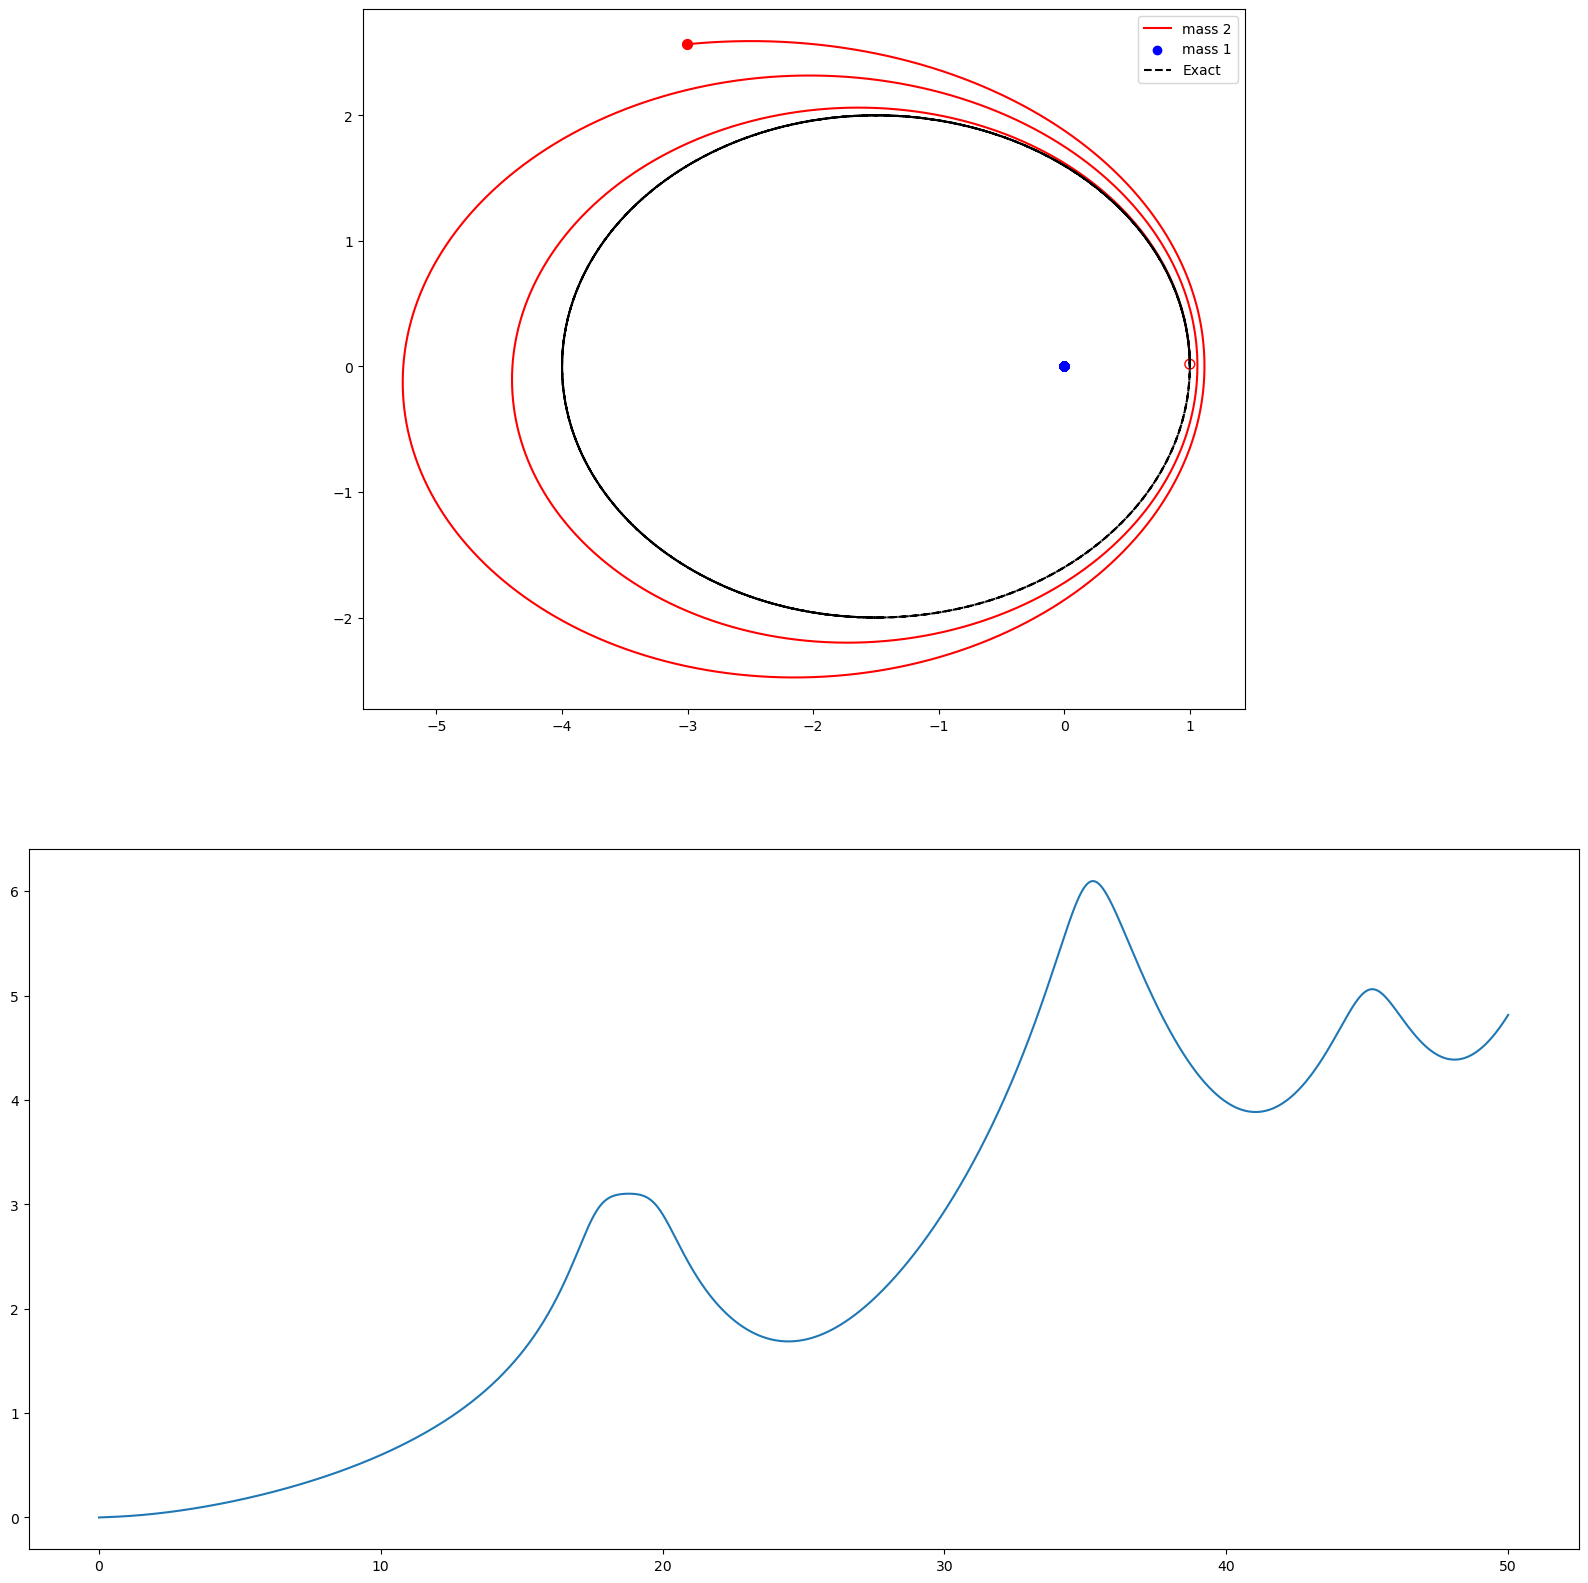

In [12]:
errs, traj, kepler_traj = AbsoluteError(EulerStep, r0s, v0s, T, h, G, m1, m2)
rs_traj = traj[1]

plt.style.use('default')

fig, (ax1, ax2) = plt.subplots(2,1, figsize = (20,20))

ax1.set_aspect('equal')
### ORBITS ###

ax1.plot(rs_traj[:,1,0], rs_traj[:,1,1], label=f'mass 2', color = 'red') # plot the orbits
ax1.scatter(rs_traj[:,0,0], rs_traj[:,0,1], label=f'mass 1', color = 'blue')
ax1.scatter(rs_traj[0,1,0],rs_traj[0,1,1], marker="o", facecolors='none', s=50, color ='red') # plot the start positions
ax1.scatter(rs_traj[-1,1,0],rs_traj[-1,1,1], marker="o",s=50, color = 'red') # plot the final positions of the
ax1.plot(kepler_traj[:,0], kepler_traj[:,1], label = 'Exact', linestyle = '--', color = 'black')
ax1.legend()

ax2.plot(traj[0], errs)

#### Tests

In [21]:
# gravity
G = 1

# mass ratio & eccentricity 
q = 0.5 # q = m2 / m1
e = 0.5

m1 = 1 # central mass
m2 = q # orbiting mass

# position
r1 = np.array([0,0.0,0.0], dtype="float64")
r2 = np.array([1,0.0,0.0], dtype="float64")

# velocity 
v1 = np.array([0,0.0,0], dtype="float64")
v2 = np.array([0,np.sqrt((1 + q)*(1 + e)),0], dtype="float64")

# create initial vectors
r0s = np.array([r1,r2])
v0s = np.array([v1,v2])
masses = np.array([m1, m2])

# reposition centre of mass to origin with no momentum 
rcom, vcom = CentreOfMass(r0s, v0s, masses)
r0s -= rcom
v0s -= vcom

T = 1000
h = 0.1

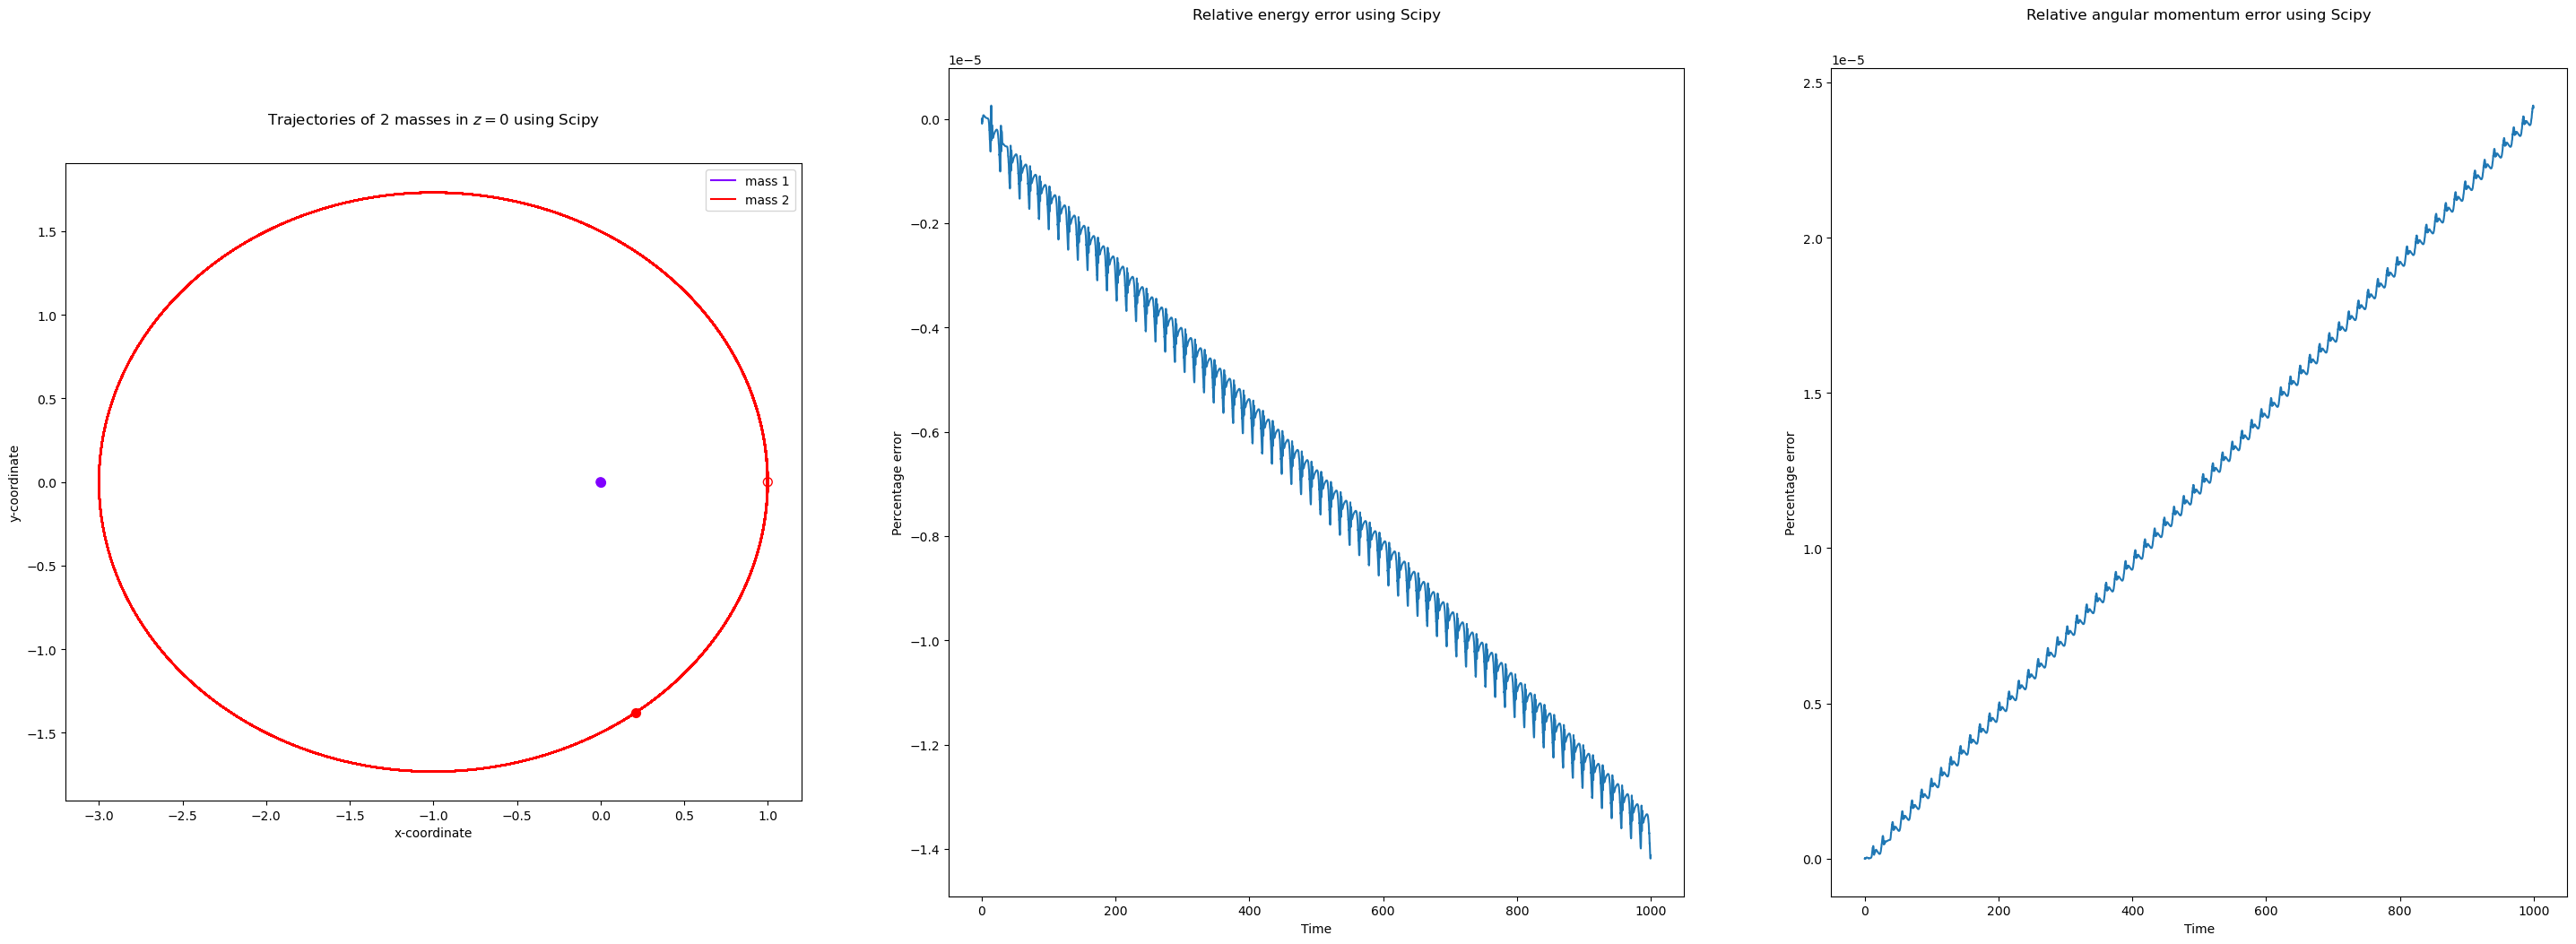

In [22]:
### Truth ###
true_traj = run_scipy(0, T, h, r0s, v0s, G, masses, centre = False)
(t_vals, rs_traj, vs_traj, ke_traj, pe_traj, am_traj) = true_traj
rs_traj = Centralise(rs_traj, 0)
true_traj = (t_vals, rs_traj, vs_traj, ke_traj, pe_traj, am_traj)
plot2D(true_traj, masses, 'Scipy', COM = False)

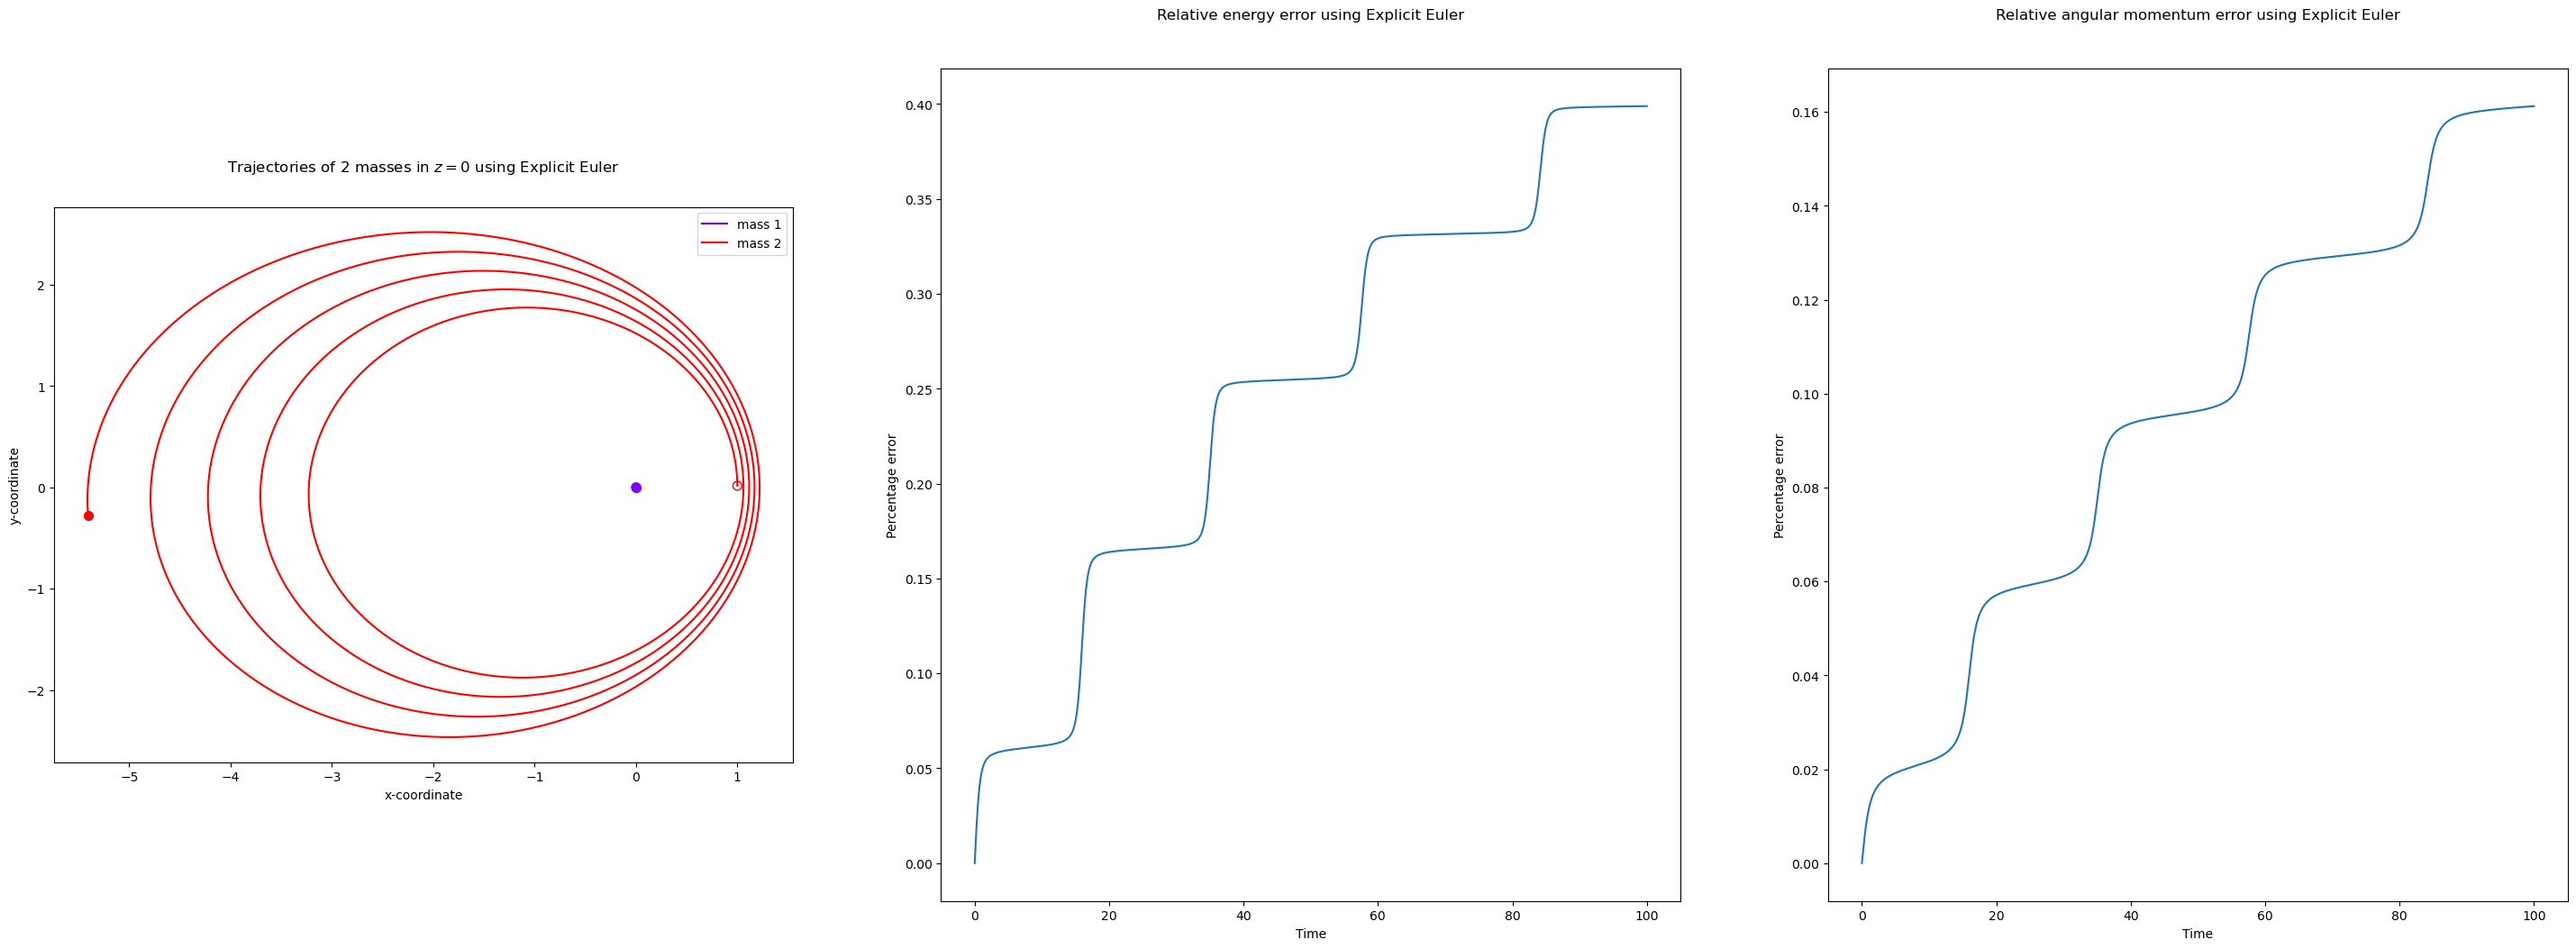

In [23]:
### Forward Euler ###
Euler_traj = run_scheme(EulerStep, 0, 100, 0.01, r0s, v0s, G, masses)
plot2D(Euler_traj, masses, 'Explicit Euler', COM = False)

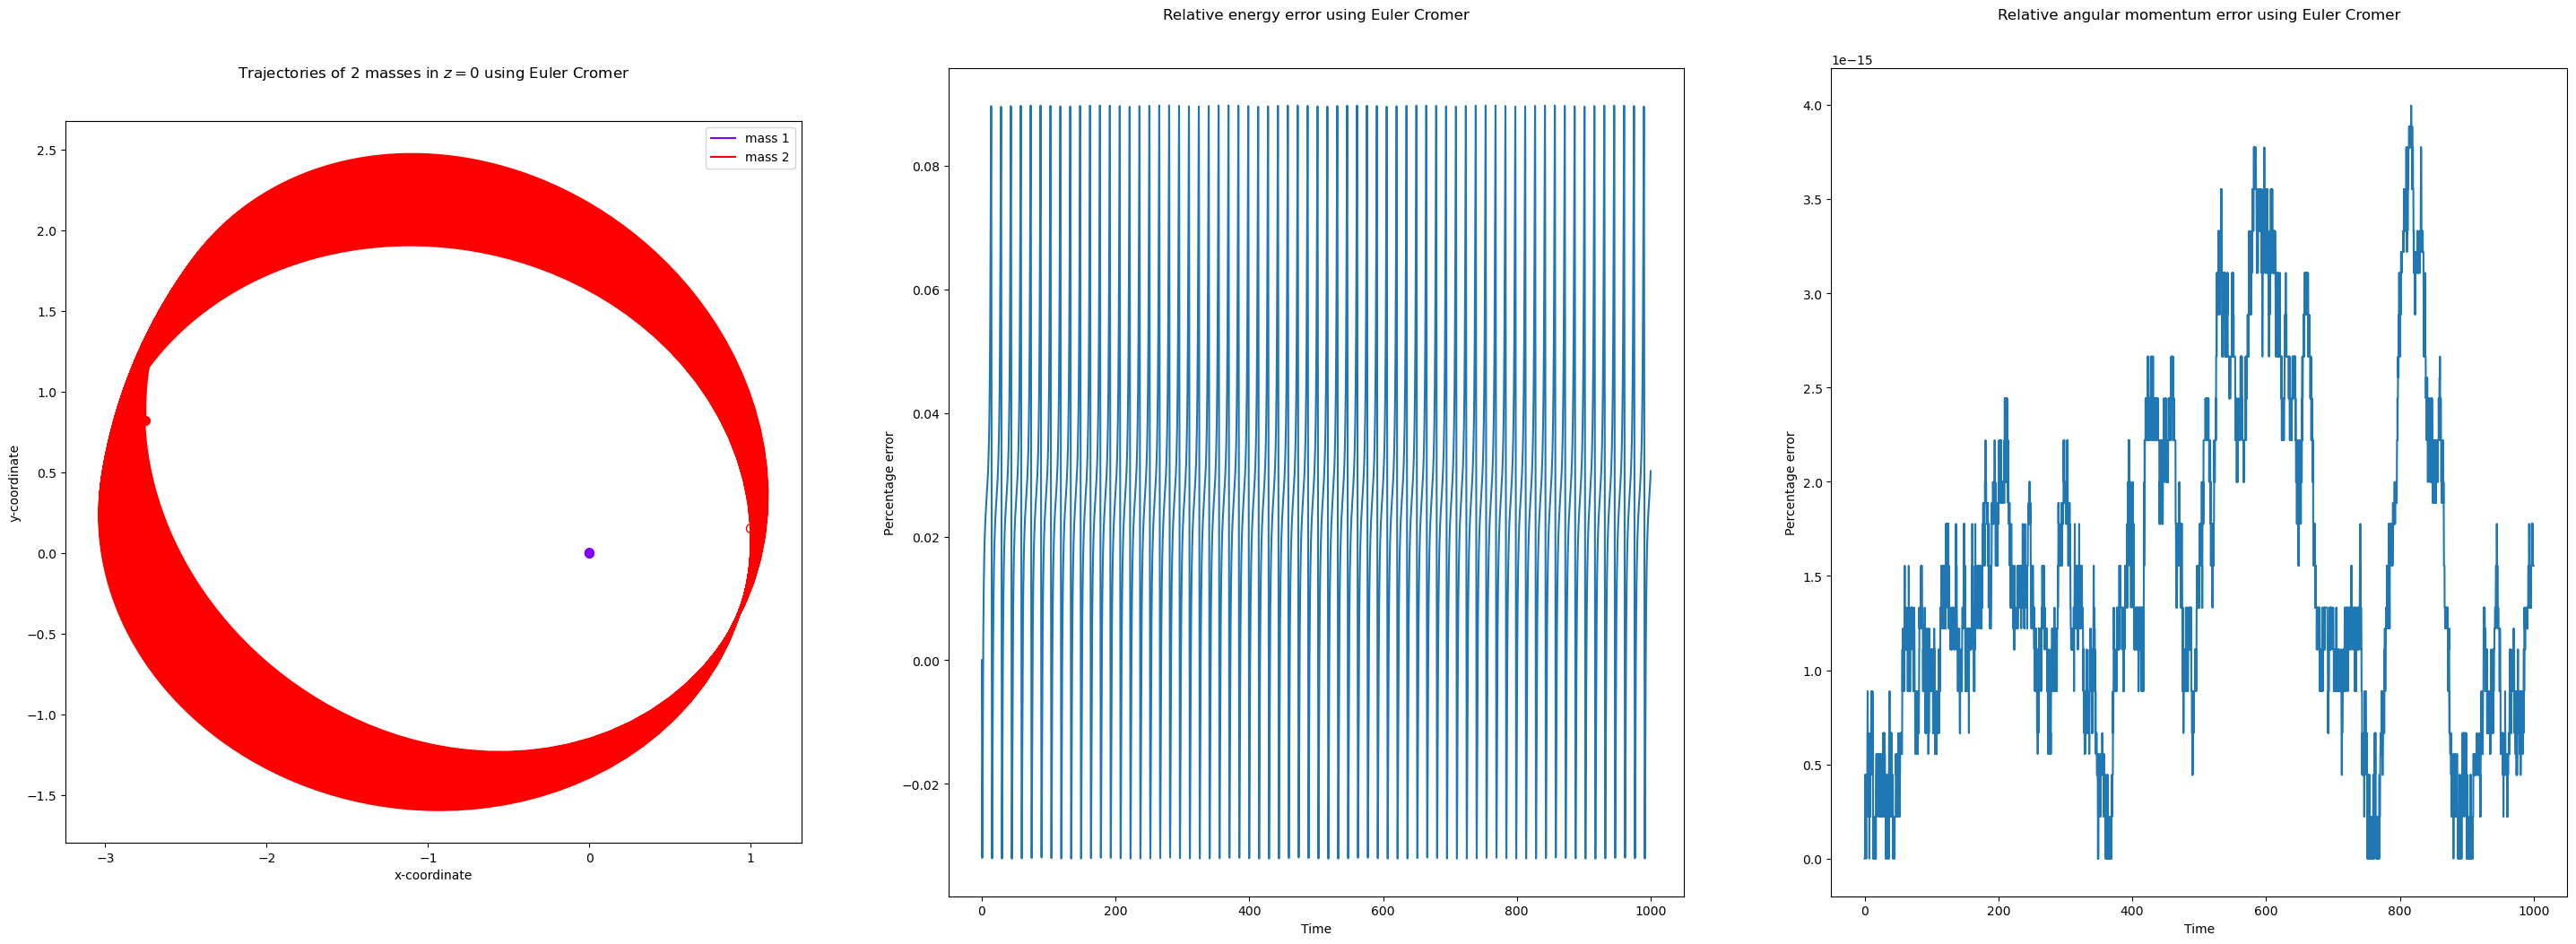

In [24]:
### Euler Cromer ###
EulerCromer_traj = run_scheme(EulerCromerStep, 0, T, h, r0s, v0s, G, masses)
plot2D(EulerCromer_traj, masses, 'Euler Cromer', COM = False)

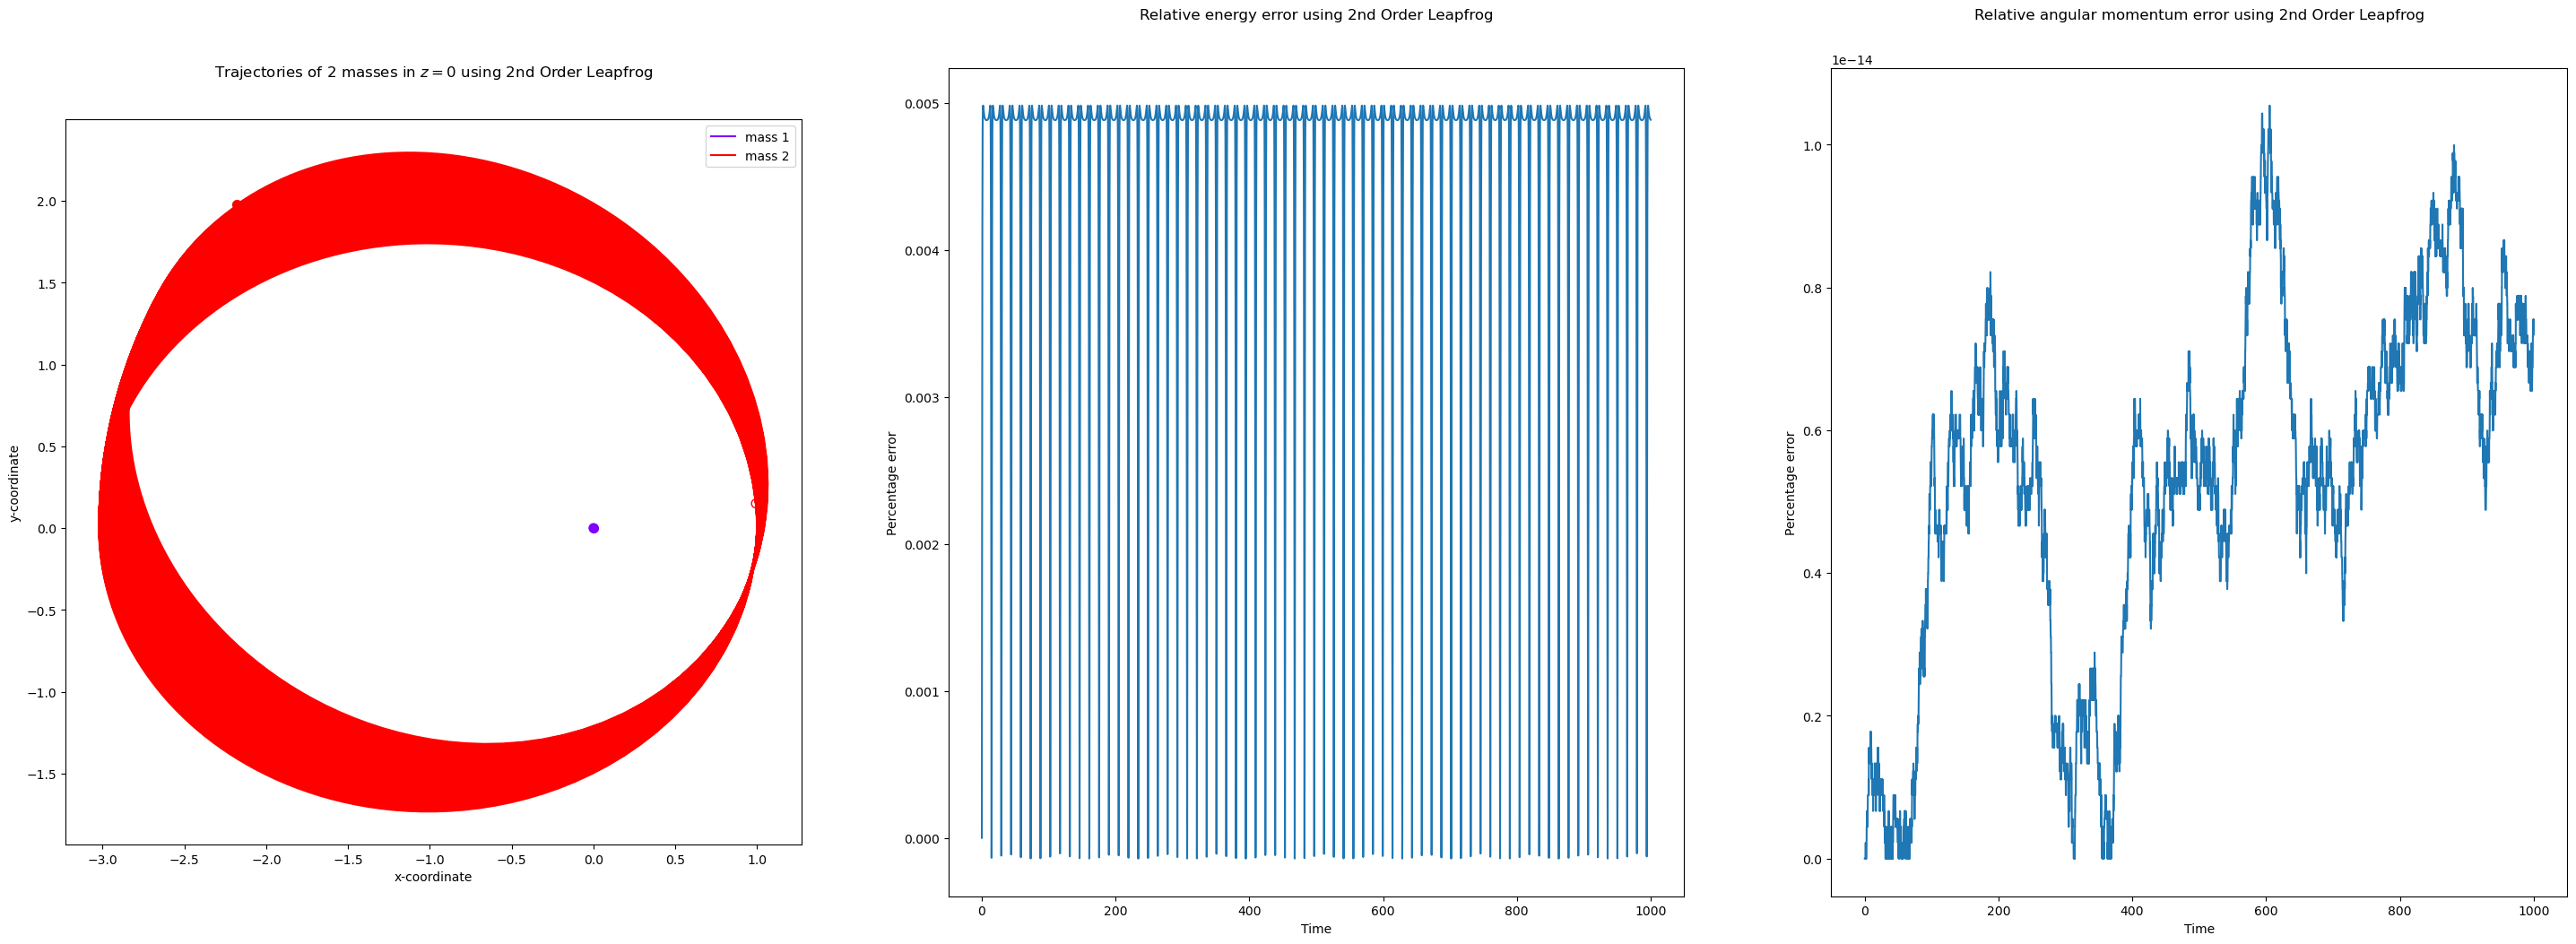

In [25]:
# ### 2nd Order Leapfrog ###
Leapfrog_traj = run_scheme(LeapfrogStep, 0, T, h, r0s, v0s, G, masses)
plot2D(Leapfrog_traj, masses, '2nd Order Leapfrog (velocity Verlet)', COM = False)

In [ ]:
# ### Position Verlet ###
pVerlet_traj = run_scheme(PositionVerlet, 0, T, h, r0s, v0s, G, masses)
plot2D(pVerlet_traj, masses, 'Position Verlet', COM = False)

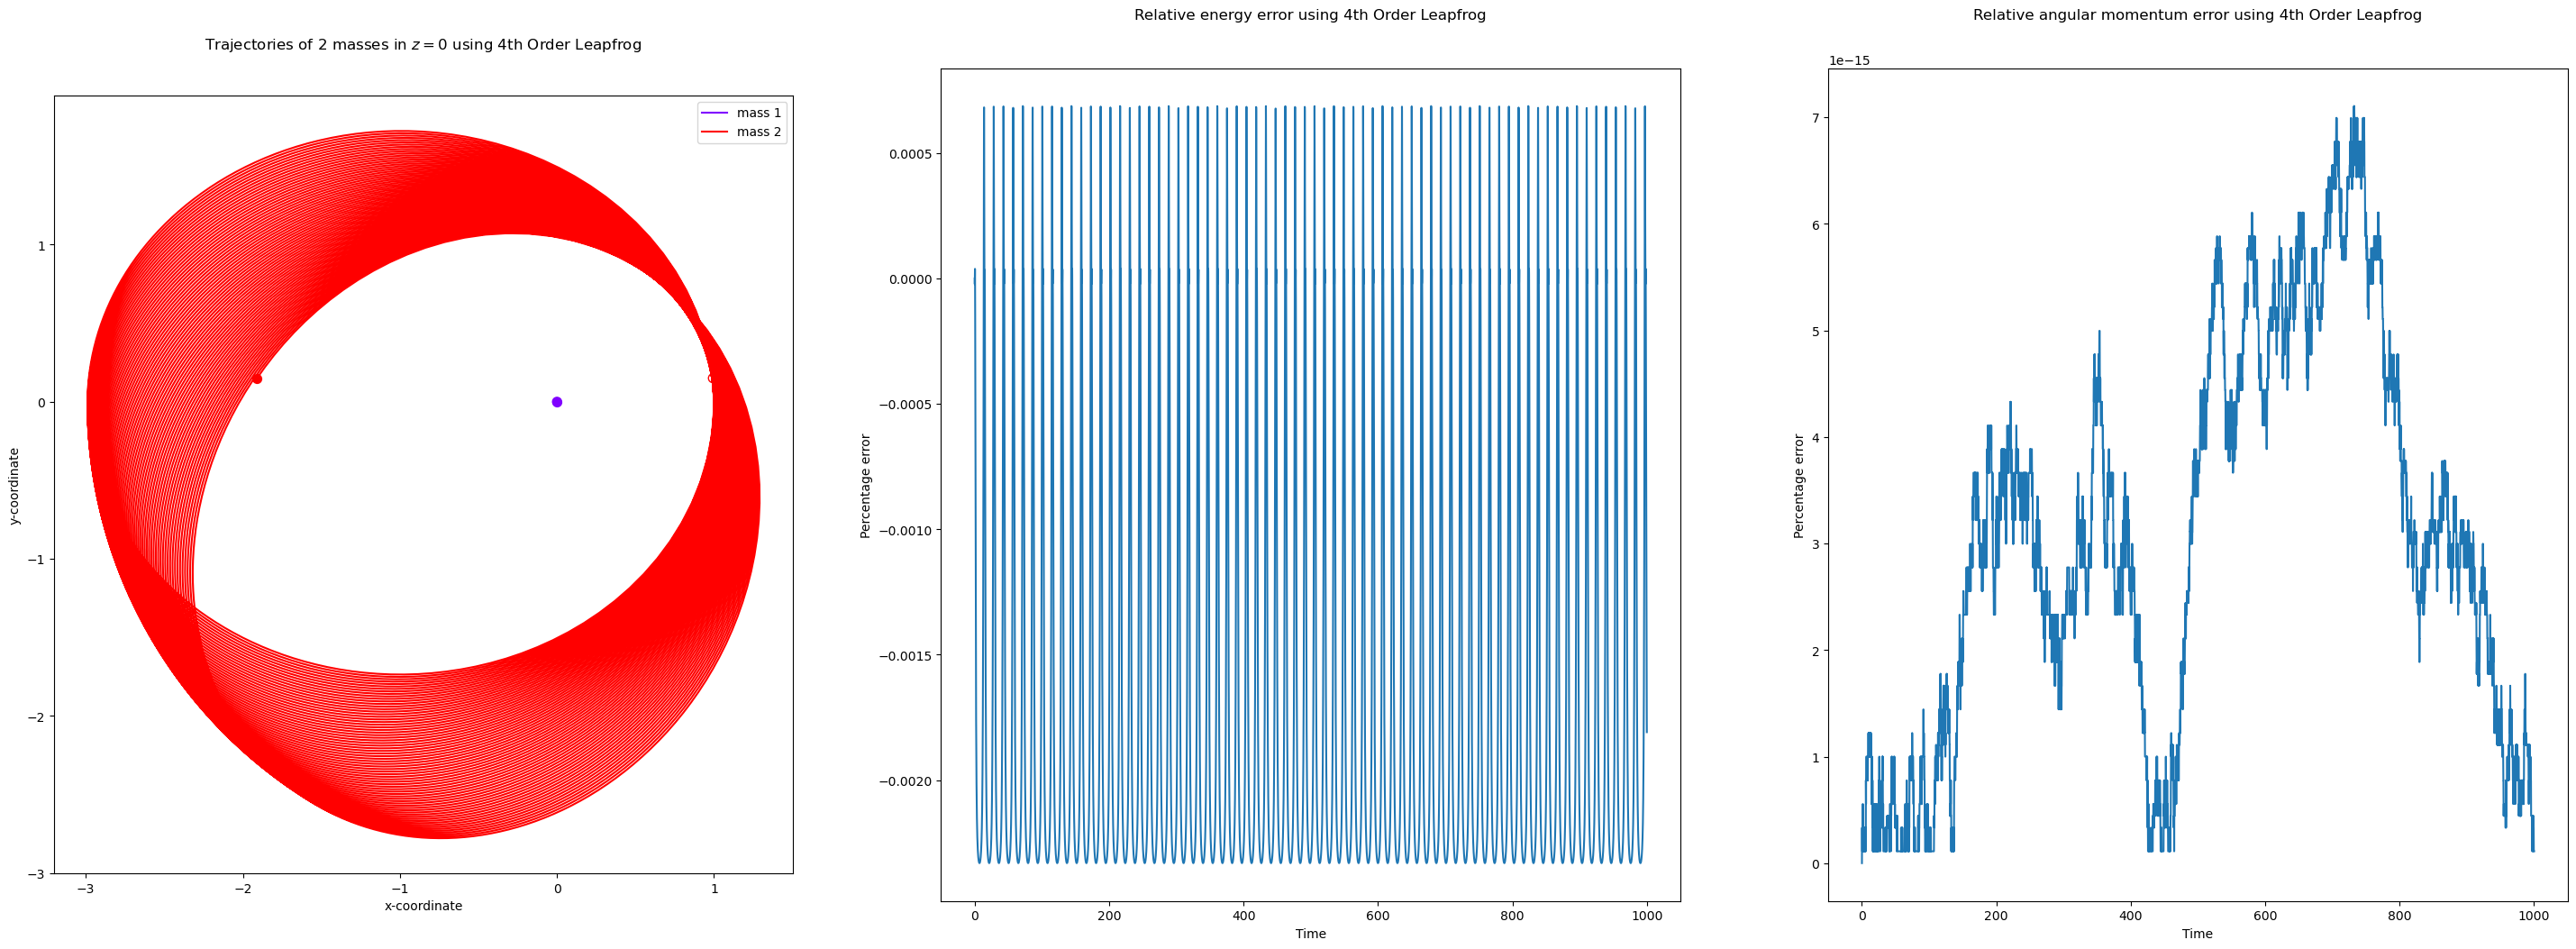

In [26]:
# ### 4th Order Leapfrog ###
Leapfrog4_traj = run_scheme(Leapfrog4Step, 0, T, h, r0s, v0s, G, masses)
plot2D(Leapfrog4_traj, masses, '4th Order Leapfrog', COM = False)

In [ ]:
# ### RK4 ###
RK4_traj = run_scheme(RK4Step, 0, T* 10, h, r0s, v0s, G, masses)
plot2D(RK4_traj, masses, 'RK4', COM = False)